# Inference

In [2]:
import openslide 
import os 
import matplotlib.pyplot as plt 
from matplotlib.patches import Rectangle
import numpy as np
from models import model_dict
import openslide 
import os
from os.path import join
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.sparse import csr_matrix
import pandas as pd
import torch
from models import model_dict
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
import cv2

In [3]:
root = '/data1/PGPD/'
root_gap_wsi = '/data1/GAP/wsi/'
root_gap_label = '/data1/GAP/Label/'
file_list = os.listdir(root_gap_wsi)
# path = os.path.join(root, '39758.svs')
path_gap = os.path.join(root_gap_wsi, file_list[0])
path_gap_mask = os.path.join(root_gap_label, file_list[0].replace('.jpg', '_L.jpg'))
path_gap

'/data1/GAP/wsi/W4-1-1-A.1.03.jpg'

In [4]:
def tessellation_wsi(wsi: openslide.OpenSlide, level = 0, save_path = None, tile_size = 150): 
    array_row, array_col, spatial = [], [], []
    is_tissue = []
    m = 0
    for i in range(0, wsi.level_dimensions[level][0], int(tile_size)):
        n=0
        for j in range(0, wsi.level_dimensions[level][1], int(tile_size)):
            # tile = wsi.read_region((i, j), level, (int(tile_size), int(tile_size)))
            # if save_path is not None: 
            #     tile.save(os.path.join(save_path, f'{i+int(tile_size/2)}_{j+int(tile_size/2)}.png'))
            # tile = np.asarray(tile, dtype=np.float32)[:, :, :3]/255
            if i + int(tile_size) <= wsi.dimensions[0] and j + int(tile_size) <= wsi.dimensions[1]: 
                spatial.append([i+int(tile_size/2), j+int(tile_size/2)])
                array_row.append(n)
                array_col.append(m)
            n+=1
        m+=1
    return np.array(spatial, dtype=int), array_row, array_col

def tessellation_tif(img: np.array, save_path = None, tile_size = 150): 
    array_row, array_col, spatial = [], [], []
    is_tissue = []
    m = 0
    for i in range(0, img.shape[1], int(tile_size)):
        n=0
        for j in range(0, img.shape[0], int(tile_size)):
            # tile = wsi.read_region((i, j), level, (int(tile_size), int(tile_size)))
            # if save_path is not None: 
            #     tile.save(os.path.join(save_path, f'{i+int(tile_size/2)}_{j+int(tile_size/2)}.png'))
            # tile = np.asarray(tile, dtype=np.float32)[:, :, :3]/255
            if i + int(tile_size) <= img.shape[1] and j + int(tile_size) <= img.shape[0]: 
                spatial.append([i+int(tile_size/2), j+int(tile_size/2)])
                array_row.append(n)
                array_col.append(m)
            n+=1
        m+=1
    return np.array(spatial, dtype=int), array_row, array_col

In [5]:
def get_wsi_image(wsi, level) -> np.array:
    level_count = wsi.level_count
    assert level in range(level_count)
    level_dimensions = wsi.level_dimensions[level]
    img = wsi.read_region((0, 0), level, level_dimensions) # 此处返回为PIL.Image格式，转化为np.array
    img = np.asarray(img, dtype=np.float32)[:, :, :3]/255
    return img

In [6]:
def get_model_name(model_path):
    """parse teacher name"""
    segments = model_path.split('/')[-2].split('_')
    if segments[0] != 'wrn':
        return segments[0]
    else:
        return segments[0] + '_' + segments[1] + '_' + segments[2]
def load_model(model_path, n_cls):
    print('==> loading teacher model')
    model_t = get_model_name(model_path)
    model = model_dict[model_t](num_classes=n_cls)
    
    # model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu'))['model'], strict=False)
    model.load_state_dict({k.replace('module.',''):v for k,v in torch.load(model_path, map_location=torch.device('cpu'))['model'].items()}) #Because parallel was used in training
    # model = torch.load(model_path)
    print('==> done')
    return model

In [7]:
class wsi_loader_infer(Dataset): 
    def __init__(self, spatial: list, wsi_path: str, tile_size: int = 150, transform = None) -> None:
        self.wsi = openslide.OpenSlide(wsi_path)
        wsi_name = wsi_path.split('/')[-1]
        self.center_list = spatial
        self.tile_size = tile_size
        self.transform = transform
    
    def __len__(self):
        return self.center_list.shape[0]

    def __getitem__(self, index):
        i, j = self.center_list[index][0], self.center_list[index][1]
        tile = self.wsi.read_region((int(i - self.tile_size/2), int(j - self.tile_size/2)), 0, (self.tile_size, self.tile_size))
        tile = np.asarray(tile, dtype=np.float32)[:, :, :3]
        if self.transform is not None: 
            tile = self.transform(image=tile)["image"]
        return tile, index

def get_spatial_dataloaders(spatial, wsi_path, tile_size: int = 150, batch_size=128, num_workers=8): 
    transform = A.Compose(
        [          
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            A.Resize(150,150),
            ToTensorV2(),
        ]
    )
    dataset = wsi_loader_infer(spatial, wsi_path, tile_size=tile_size, transform=transform)
    dataloader = DataLoader(dataset,
                            batch_size=batch_size,
                            shuffle=False,
                            num_workers=num_workers)
    return dataloader

def inference_adata_wsi(dataloader, model, device):
    model.eval()
    output_all = torch.tensor([]).to(device)
    with torch.no_grad():
        for input, _ in tqdm(dataloader):
            input = input.to(device)
            output = model(input)
            softmax = torch.nn.Softmax(dim=1)
            output = softmax(output)
            output_all = torch.cat((output_all, output))
    return output_all # Softmax

In [8]:
class img_loader_infer(Dataset): 
    def __init__(self, spatial: list, img: np.array, tile_size: int = 150, transform = None) -> None:
        self.img = img
        self.center_list = spatial
        self.tile_size = tile_size
        self.transform = transform
    
    def __len__(self):
        return self.center_list.shape[0]

    def __getitem__(self, index):
        i, j = self.center_list[index][1], self.center_list[index][0]
        tile = self.img[int(i - self.tile_size/2): int(i + self.tile_size/2), int(j - self.tile_size/2):int(j + self.tile_size/2)]
        tile = np.asarray(tile, dtype=np.float32)[:, :, :3]
        if self.transform is not None: 
            tile = self.transform(image=tile)["image"]
        return tile, index

def img_get_spatial_dataloaders(spatial, img, tile_size: int = 150, batch_size=128, num_workers=8): 
    transform = A.Compose(
        [          
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            A.Resize(150,150),
            ToTensorV2(),
        ]
    )
    dataset = img_loader_infer(spatial, img, tile_size=tile_size, transform=transform)
    dataloader = DataLoader(dataset,
                            batch_size=batch_size,
                            shuffle=False,
                            num_workers=num_workers)
    return dataloader

def inference_adata_wsi(dataloader, model, device):
    model.eval()
    output_all = torch.tensor([]).to(device)
    with torch.no_grad():
        for input, _ in tqdm(dataloader):
            input = input.to(device)
            output = model(input)
            softmax = torch.nn.Softmax(dim=1)
            output = softmax(output)
            output_all = torch.cat((output_all, output))
    return output_all # Softmax

In [9]:
wsi_im = cv2.imread(path_gap)
wsi_im = cv2.cvtColor(wsi_im, cv2.COLOR_BGR2RGB)

In [10]:
# wsi = openslide.OpenSlide(path)
model_path = '/home/lthpc/zhongzh/RFD4Hist/save/models/ResNet18_ivygap_lr_0.05_decay_0.0005_trial_0/ResNet18_best.pth'

In [11]:
spatial,_,_ = tessellation_tif(wsi_im)
spatial

array([[   75,    75],
       [   75,   225],
       [   75,   375],
       ...,
       [14925, 17625],
       [14925, 17775],
       [14925, 17925]])

In [12]:
model = load_model(model_path, n_cls=8)

==> loading teacher model
==> done


In [13]:
device = torch.device('cuda:6' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(device)
dataloader = img_get_spatial_dataloaders(spatial, wsi_im, batch_size=16)
# dataloader = get_adata_dataloaders(adata, path, batch_size=64, num_workers=8)
output_all = inference_adata_wsi(dataloader, model, device)

  0%|          | 0/750 [00:00<?, ?it/s]

cuda:6


100%|██████████| 750/750 [00:30<00:00, 24.63it/s]


In [45]:
spatial, _, _ = tessellation_wsi(wsi)
spatial

array([[   75,    75],
       [   75,   225],
       [   75,   375],
       ...,
       [43725, 25725],
       [43725, 25875],
       [43725, 26025]])

In [46]:
device = torch.device('cuda:6' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(device)
dataloader = get_spatial_dataloaders(spatial, path, batch_size=64)
# dataloader = get_adata_dataloaders(adata, path, batch_size=64, num_workers=8)
output_all = inference_adata_wsi(dataloader, model, device)


  0%|          | 0/794 [00:00<?, ?it/s]

cuda:6


/home/lthpc/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100%|██████████| 794/794 [01:04<00:00, 12.27it/s]


In [14]:
output_all = output_all.cpu().numpy()
a = np.concatenate((spatial, output_all), axis=1)
a.shape

(12000, 10)

In [15]:
df = pd.DataFrame(a, columns=[
    'x',
    'y',
    "CTne",
    "IT",
    "LE",
    "CT",
    "CTmvp",
    "CTpan",
    "CTpnz",
    "BG"
])
df.head()

,x,y,CTne,IT,LE,CT,CTmvp,CTpan,CTpnz,BG
0,75.0,75.0,0.020393,0.000773,0.000474,0.000233,0.000400,0.000072,0.000321,0.977334
1,75.0,225.0,0.020696,0.000777,0.000432,0.000232,0.000401,0.000062,0.000320,0.977079
2,75.0,375.0,0.019883,0.000742,0.000412,0.000221,0.000389,0.000060,0.000299,0.977994
3,75.0,525.0,0.021279,0.000800,0.000505,0.000243,0.000425,0.000073,0.000337,0.976336
4,75.0,675.0,0.023256,0.000933,0.000522,0.000284,0.000530,0.000081,0.000388,0.974006


In [16]:
df.to_csv(f'{file_list[0]}.csv', index=False)

In [59]:
wsi.level_dimensions

((43842, 26157), (10960, 6539), (2740, 1634))

# Visualization

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
from matplotlib.patches import Rectangle
import os 
import openslide
from tqdm import tqdm

In [2]:
root = '/data1/PGPD/'
path = os.path.join(root, '39758.svs')

In [3]:
wsi = openslide.OpenSlide(path)
df = pd.read_csv('39758.csv')
df.head()

,x,y,CTne,IT,LE,CT,CTmvp,CTpan,CTpnz,BG
0,75.0,75.0,0.001830,1.695560e-07,0.000014,0.000127,7.765918e-03,8.604568e-04,0.000001,9.894008e-01
1,75.0,225.0,0.004787,3.164976e-07,0.000018,0.000312,1.300372e-02,9.805365e-04,0.000004,9.808939e-01
2,75.0,375.0,0.000028,1.100886e-05,0.003574,0.996381,5.289862e-07,1.016440e-08,0.000005,2.221769e-08
3,75.0,525.0,0.001951,2.907390e-07,0.000021,0.000169,8.641301e-03,5.292729e-04,0.000001,9.886876e-01
4,75.0,675.0,0.003368,5.124422e-07,0.000033,0.000315,1.321156e-02,7.954312e-04,0.000003,9.822734e-01


In [17]:
np.array(df)

array([[7.50000000e+01, 7.50000000e+01, 2.03925017e-02, ...,
        7.15922142e-05, 3.20650928e-04, 9.77334440e-01],
       [7.50000000e+01, 2.25000000e+02, 2.06957068e-02, ...,
        6.24672102e-05, 3.20252235e-04, 9.77079451e-01],
       [7.50000000e+01, 3.75000000e+02, 1.98832173e-02, ...,
        6.01878382e-05, 2.99060077e-04, 9.77993846e-01],
       ...,
       [1.49250000e+04, 1.76250000e+04, 1.77360326e-02, ...,
        6.14003948e-05, 2.66444229e-04, 9.80417967e-01],
       [1.49250000e+04, 1.77750000e+04, 1.87585503e-02, ...,
        6.34846656e-05, 2.85079674e-04, 9.79259968e-01],
       [1.49250000e+04, 1.79250000e+04, 1.94337517e-02, ...,
        7.77138557e-05, 3.07027338e-04, 9.78406727e-01]])

In [18]:
classes = list(df.columns)[2:]
colors = ['black', 'pink', 'blue', 'purple', 'red', 'orange', 'gray', 'white']
COLOR_DICT = dict(zip(classes, colors))
COLOR_DICT

{'CTne': 'black',
 'IT': 'pink',
 'LE': 'blue',
 'CT': 'purple',
 'CTmvp': 'red',
 'CTpan': 'orange',
 'CTpnz': 'gray',
 'BG': 'white'}

In [22]:
class patch_generator():
    
    def __init__(self, info: pd.DataFrame, size = 150, downsample = 16) -> None:
        self.x = (np.array(info['x']) - size)
        self.y = (np.array(info['y']) - size)
        self.prob = np.array(info.iloc[:, 2:])
        self.type = info.iloc[:, 2:].idxmax(axis=1)
        self.size = size 
        self.downsample = downsample

    def len(self): 
        return len(self.x)

    def generate_patch(self):
        for i in range(len(self.x)): 
            yield Rectangle(
                (self.x[i]/self.downsample, self.y[i]/self.downsample), 
                self.size/self.downsample,
                self.size/self.downsample, 
                color = COLOR_DICT[self.type[i]], 
                alpha = 0.5
            )
    def generate_channels(self, im_size = (150,150)): 
        im = np.zeros((im_size[0],im_size[1], 8))
        for i in range(len(self.x)):
            im[int(self.y[i]/self.size), int(self.x[i]/self.size)] = self.prob[i]
        return im 
        
        

In [23]:
def get_wsi_image(wsi, level) -> np.array:
    level_count = wsi.level_count
    assert level in range(level_count)
    level_dimensions = wsi.level_dimensions[level]
    img = wsi.read_region((0, 0), level, level_dimensions) # 此处返回为PIL.Image格式，转化为np.array
    img = np.asarray(img, dtype=np.float32)[:, :, :3]/255
    return img

In [24]:
patch_gen = patch_generator(df)
img = patch_gen.generate_channels()
img[:,:,0]

array([[0.02433797, 0.02073102, 0.02423607, ..., 0.        , 0.        ,
        0.        ],
       [0.02253015, 0.01996545, 0.01984863, ..., 0.        , 0.        ,
        0.        ],
       [0.021058  , 0.02168925, 0.0220669 , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

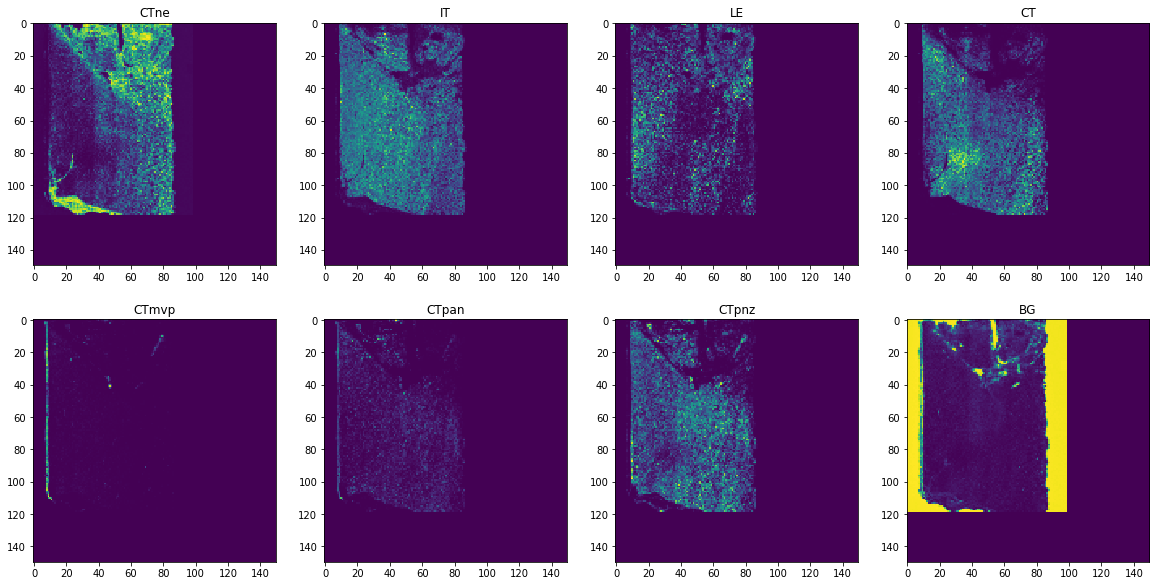

In [25]:
fig, axes = plt.subplots(2,4, figsize = (20,10))
for i, type in enumerate(classes):
    axes[int(np.floor(i/4)), int(i%4)].imshow(img[:,:,i])
    # axes[int(np.floor(i/4)), int(i%4)].title(type)
    axes[int(np.floor(i/4)), int(i%4)].set_title(type) 
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

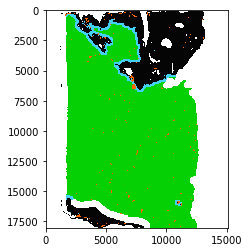

In [26]:
wsi_im_label = cv2.imread(path_gap_mask)
wsi_im_label = cv2.cvtColor(wsi_im_label, cv2.COLOR_BGR2RGB)
plt.imshow(wsi_im_label)
plt.show()

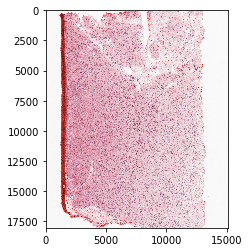

In [27]:
plt.imshow(wsi_im)
plt.show()

50808it [00:37, 1350.35it/s]


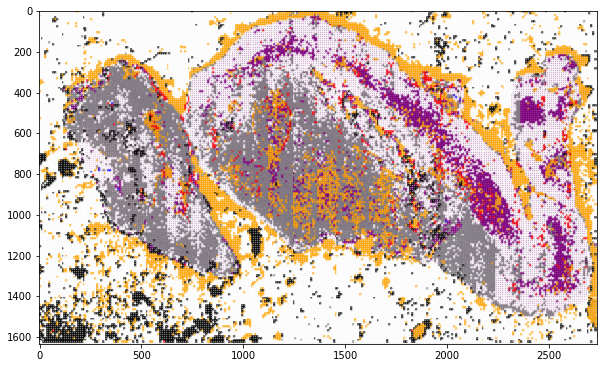

In [56]:
im = get_wsi_image(wsi, 2)
fig, ax = plt.subplots(figsize=(10,20))
ax.imshow(wsi_im)
patch_gen = patch_generator(df)
for rec in tqdm(patch_gen.generate_patch()):
    ax.add_patch(rec)
plt.show()

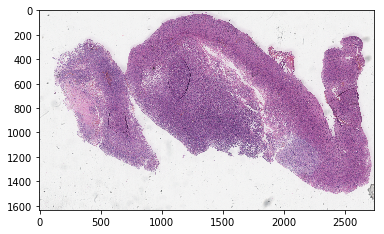

In [16]:
plt.imshow(im)
plt.show()

In [66]:
im.shape

(1634, 2740, 3)

- [ ] 尝试在ivyGAP数据集上进行可视化
- [ ] PGPD可视化效果较差
- [ ] TCGA上也可以试试，因为是svs格式

In [1]:
a = [
    'x',
    'y',
    "CTne",
    "IT",
    "LE",
    "CT",
    "CTmvp",
    "CTpan",
    "CTpnz",
    "BG"
]
a

['x', 'y', 'CTne', 'IT', 'LE', 'CT', 'CTmvp', 'CTpan', 'CTpnz', 'BG']